In [51]:
import time
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import sys
sys.path.append('/dropletAnalysisTools_2_0.py')
import dropletAnalysisTools_2_0 as dat

%matplotlib inline

# 0) Select directories

In [52]:
RAW_IMAGE_DIR = 'L0'

IMAGE_OUTPUT_DIR = RAW_IMAGE_DIR + '/IMAGES/'
PLOT_OUTPUT_DIR = RAW_IMAGE_DIR + '/PLOTS/'

dat.RAW_IMAGE_DIR = RAW_IMAGE_DIR
dat.IMAGE_OUTPUT_DIR = IMAGE_OUTPUT_DIR
dat.PLOT_OUTPUT_DIR = PLOT_OUTPUT_DIR

if not os.path.exists(IMAGE_OUTPUT_DIR):
    os.makedirs(IMAGE_OUTPUT_DIR)
if not os.path.exists(PLOT_OUTPUT_DIR):
    os.makedirs(PLOT_OUTPUT_DIR)

# 1) Tune LUTs for cell and droplet identification

### Set scalebar constant

In [53]:
umPerPixel = 0.23

### Choose fluoresence channels and LUT scales

In [54]:
BF_TAG = '_BF.tif'
RFP_TAG = '_TxR.tif'
GFP_TAG = '_FITC.tif'
CFP_TAG = '_CFP.tif'
YFP_TAG = '_YFP.tif'

TAGS = [BF_TAG, RFP_TAG, GFP_TAG, CFP_TAG]

In [11]:
dat.BF_TAG = BF_TAG
dat.RFP_TAG = RFP_TAG
dat.GFP_TAG = GFP_TAG
dat.CFP_TAG = CFP_TAG
dat.YFP_TAG = YFP_TAG
dat.TAGS = [BF_TAG, RFP_TAG, YFP_TAG, CFP_TAG]

### Load files

In [12]:
roots, fullpaths = dat.pull_image_roots(RAW_IMAGE_DIR)

In [13]:
test_root = fullpaths[2]

### Overwriting/Tuning Scales (adjust LUTs)

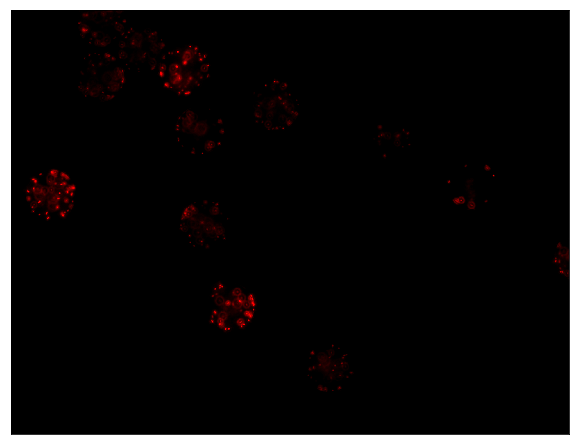

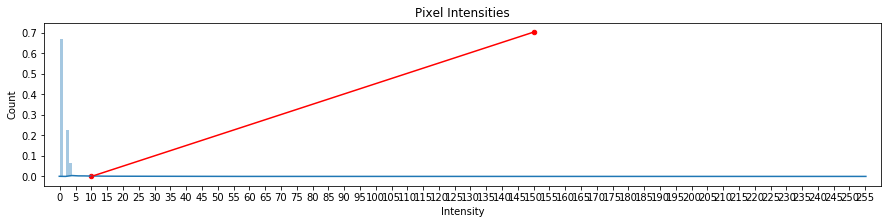

<Figure size 432x288 with 0 Axes>

In [14]:
RFP_SCALE = [10, 150]

c = dat.loadAndScaleImage(test_root+RFP_TAG, scale=RFP_SCALE, display=True, hist=True)

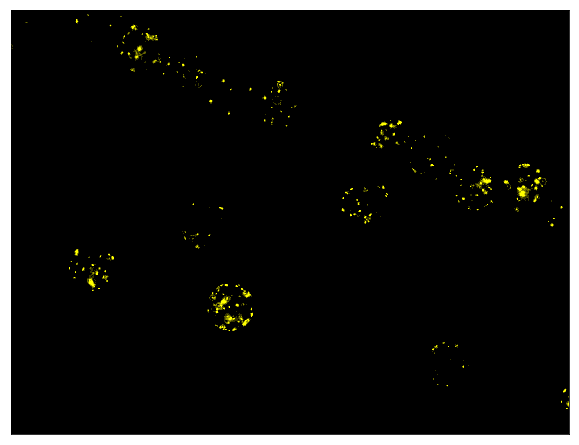

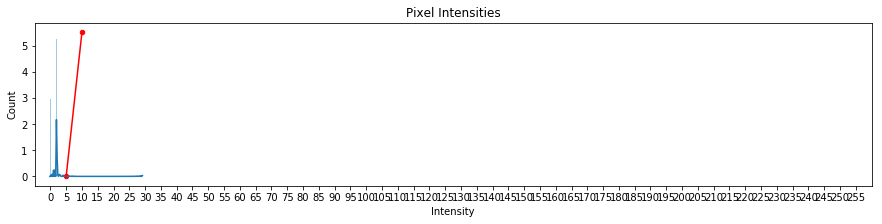

<Figure size 432x288 with 0 Axes>

In [15]:
YFP_SCALE = [5, 10]

c = dat.loadAndScaleImage(test_root+YFP_TAG, scale=YFP_SCALE, display=True, hist=True)

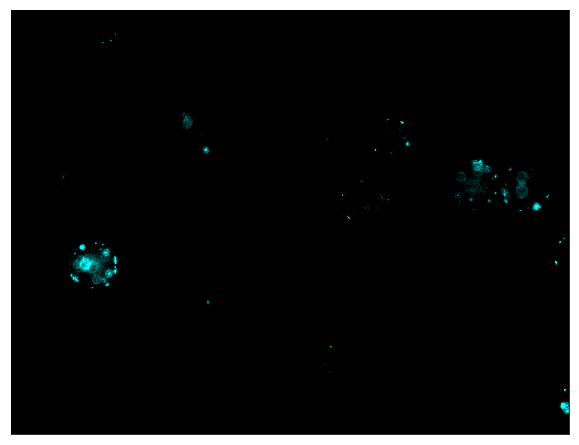

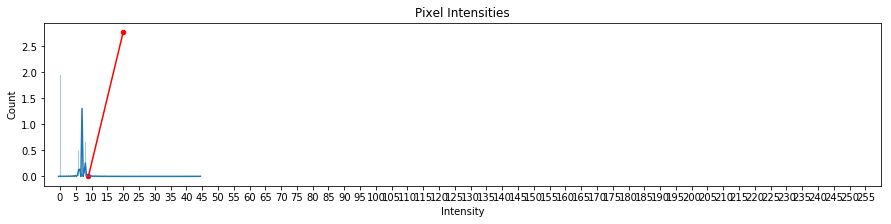

<Figure size 432x288 with 0 Axes>

In [16]:
CFP_SCALE = [9, 20]

c = dat.loadAndScaleImage(test_root+CFP_TAG, scale=CFP_SCALE, display=True, hist=True)

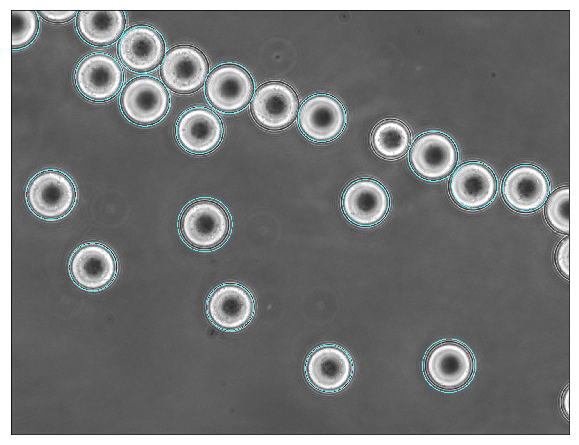

In [17]:
BF_SCALE = [0, 255]
DIAMETER_VAL=175
THRESHOLD_VAL=50

loaded_BF_img = dat.loadAndScaleImage(test_root+BF_TAG, scale=BF_SCALE, display=False)
circumscribed_BF_img, circles = dat.findCirclesFromBF(loaded_BF_img, diameter_val=DIAMETER_VAL, threshold_val=THRESHOLD_VAL, display=True)

### Verify Scale List

In [18]:
SCALES = [BF_SCALE, RFP_SCALE, YFP_SCALE, CFP_SCALE]

In [19]:
BF_TAG = TAGS[0]
BF_SCALE = SCALES[0]

FLUOR_TAGS = TAGS[1:]
FLUOR_SCALES = SCALES[1:]

In [20]:
dat.SCALES = SCALES
dat.BF_TAG = BF_TAG
dat.BF_SCALE = BF_SCALE
dat.FLUOR_TAGS = FLUOR_TAGS
dat.FLUOR_SCALES = FLUOR_SCALES

# 2) Check Alignment of channels

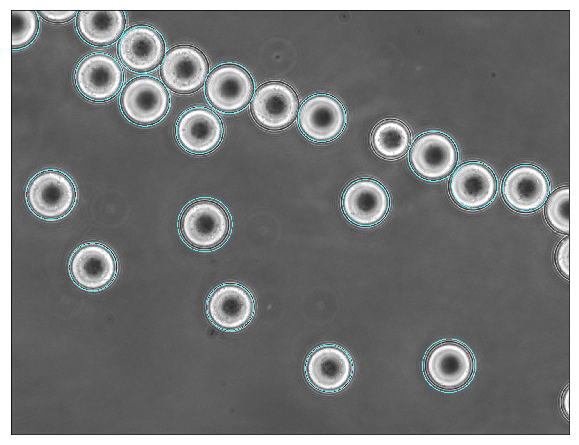

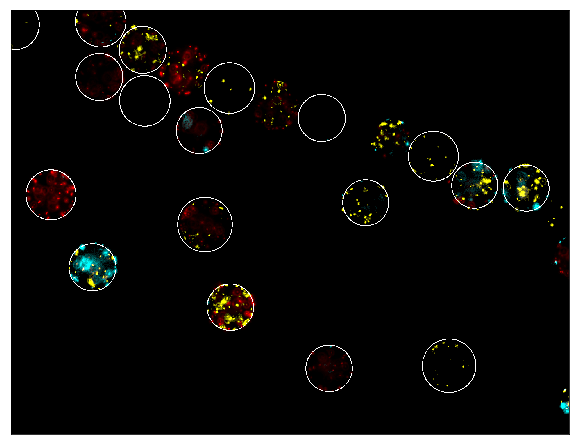

In [21]:
loaded_BF_img = dat.loadAndScaleImage(test_root+BF_TAG, scale=BF_SCALE, display=False)
circumscribed_BF_img, circles = dat.findCirclesFromBF(loaded_BF_img, diameter_val=DIAMETER_VAL, threshold_val=THRESHOLD_VAL, display=True)

loaded_channels = []
for fluor_tag, fluor_scale in zip(FLUOR_TAGS, FLUOR_SCALES):
    
    loaded_image = dat.loadAndScaleImage(test_root+fluor_tag, scale=fluor_scale)
    loaded_channels.append(loaded_image)

loaded_channels = np.array(loaded_channels)
combined_fluor_img = np.amax(loaded_channels, axis=0)

circumscribed_combined_fluor_img = dat.drawCirclesOnImage(combined_fluor_img, circles)
dat.printImage(circumscribed_combined_fluor_img)

# 3) Check all image alignments

1/8


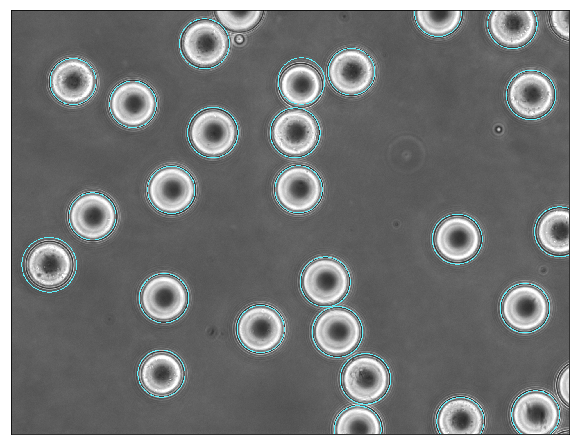

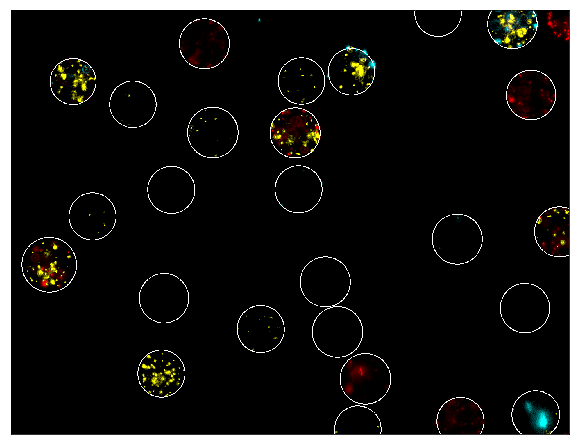

2/8


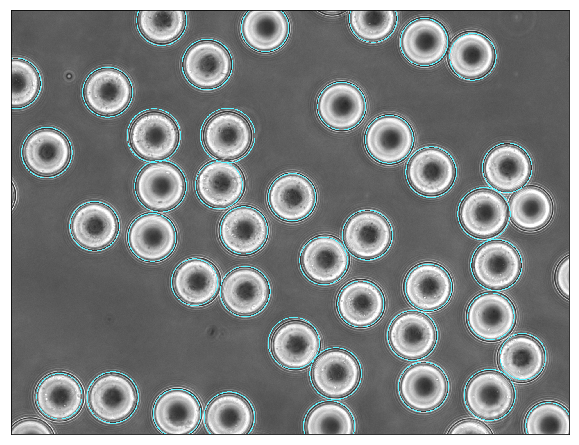

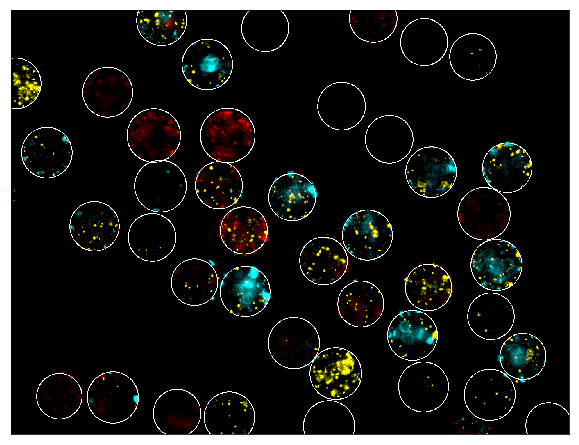

3/8


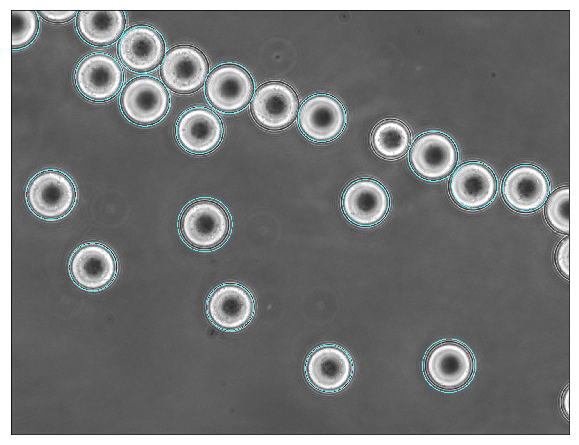

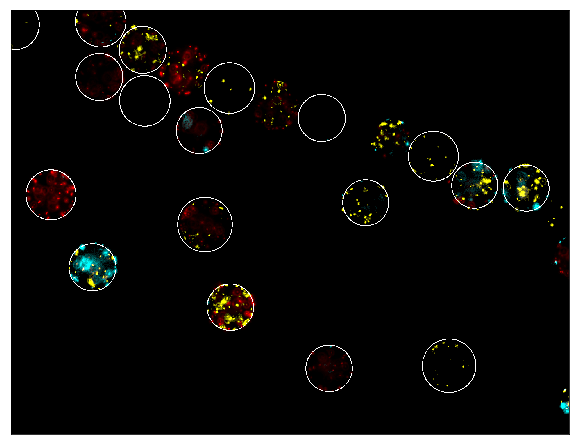

4/8


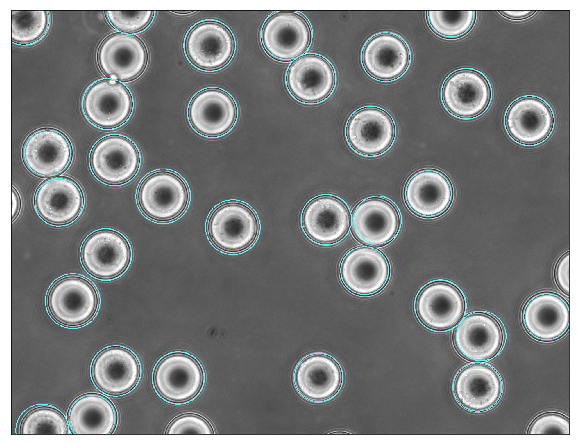

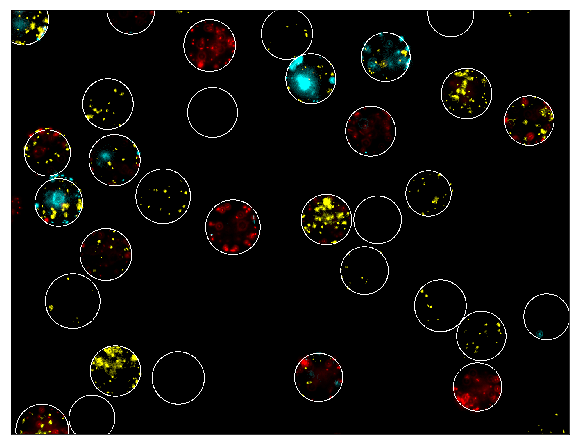

5/8


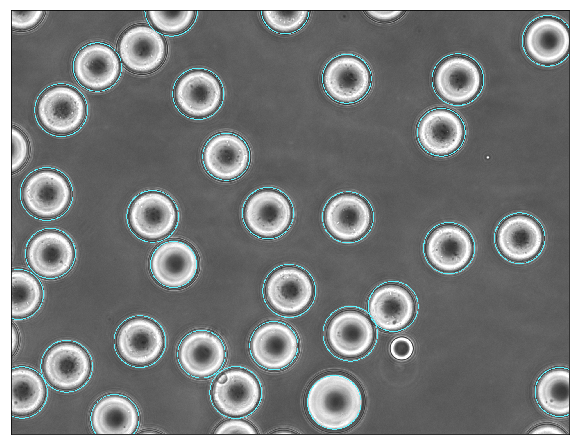

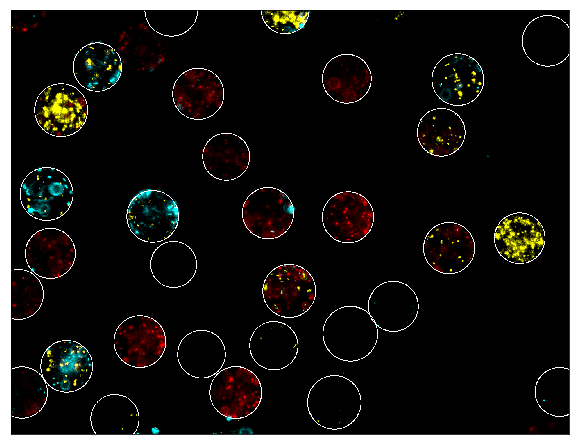

6/8


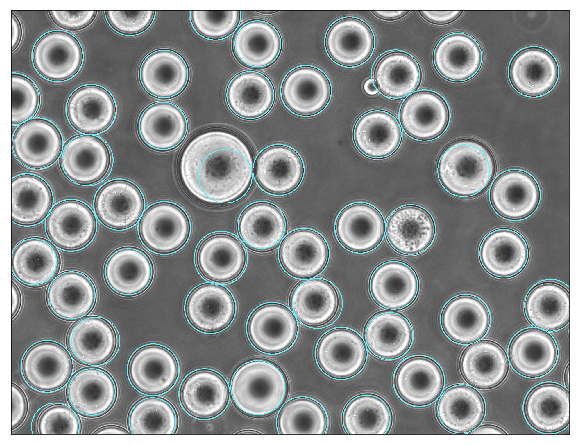

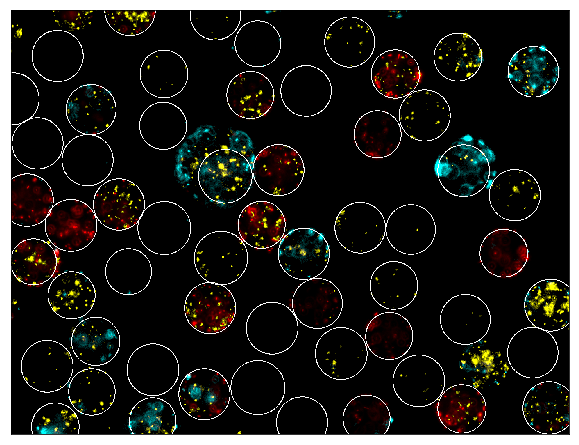

7/8


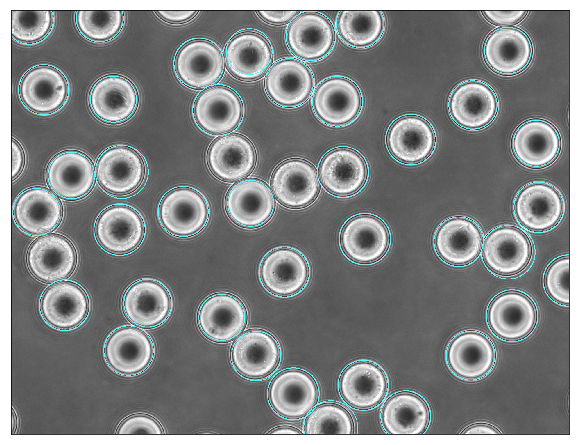

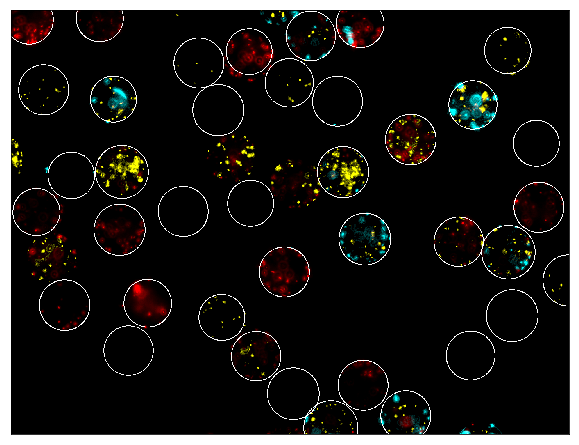

8/8


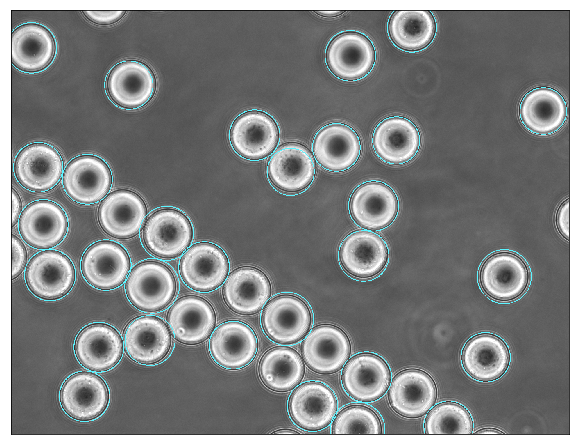

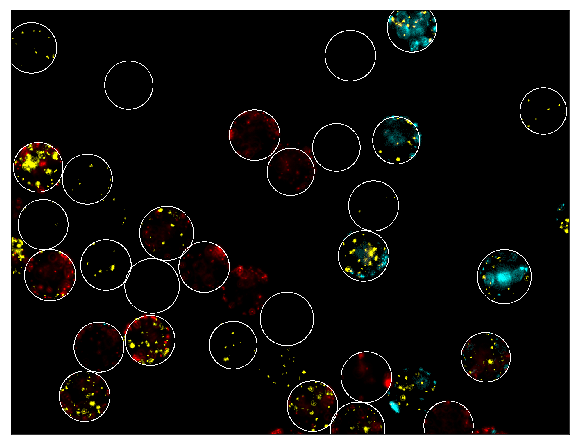

In [22]:
extracted_circles_dict = dat.extractAllCircleRegions(fullpaths, DIAMETER_VAL, THRESHOLD_VAL, TAGS, SCALES)

### Size distribution

In [23]:
diameters = [d.shape[0]*umPerPixel for d in extracted_circles_dict[BF_TAG]]    

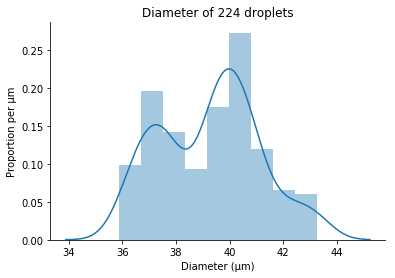

In [24]:
sns.distplot(diameters)
plt.title('Diameter of ' + str(len(diameters)) +' droplets')
plt.xlabel(u'Diameter (µm)')
plt.ylabel(u'Proportion per µm')
sns.despine()
plt.savefig(PLOT_OUTPUT_DIR+'distribution.png', dpi=450)

# 4) Compile extracted droplets

In [25]:
masked_droplets = dat.getMaskedDropletObjects(extracted_circles_dict)

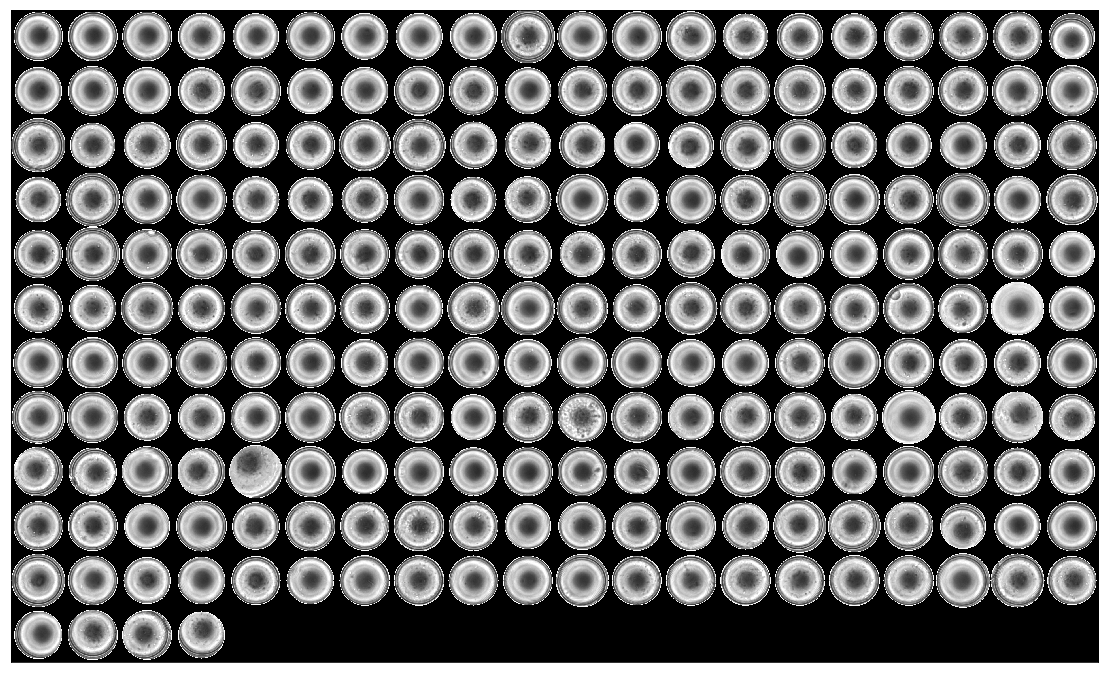

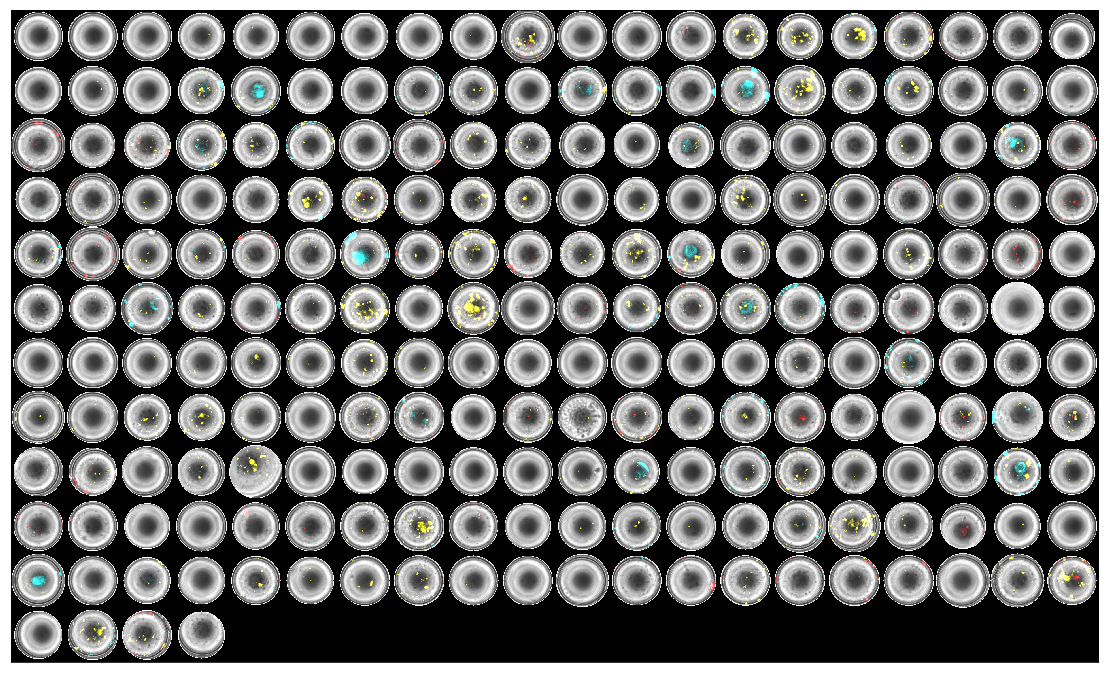

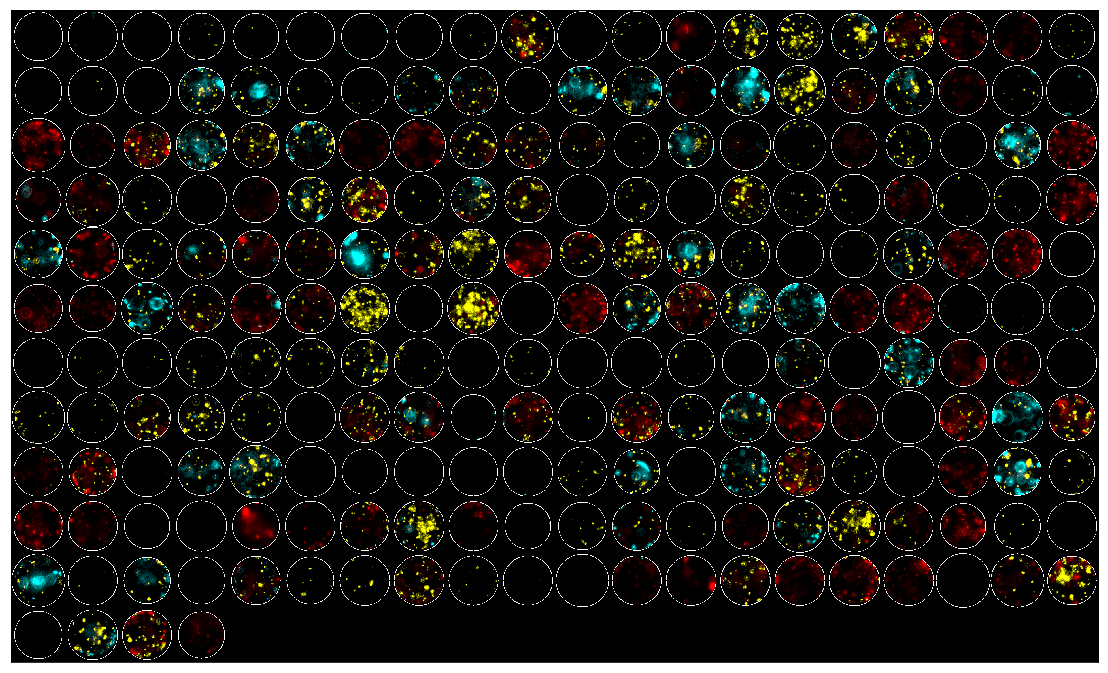

In [26]:
dat.printDropletMatrix(masked_droplets, channels=dat.channelsWithSuffix([BF_TAG], '_whiteline'),
                       filename='grid_all_BF.png')
dat.printDropletMatrix(masked_droplets, channels=dat.channelsWithSuffix(TAGS, '_whiteline'),
                       filename='grid_all_channels.png')
dat.printDropletMatrix(masked_droplets, channels=dat.channelsWithSuffix(FLUOR_TAGS, '_whiteline'),
                       filename='grid_all_fluor.png')

# 5) Quantify Fluorescence and output

In [28]:
fluorescence_droplets = []
for d in masked_droplets:
    fluorescence_droplet = dat.dropletFluorescenceMean(d, YFP_TAG)
    fluorescence_droplet = dat.dropletFluorescenceMean(fluorescence_droplet, RFP_TAG)
    fluorescence_droplet = dat.dropletFluorescenceMean(fluorescence_droplet, CFP_TAG)
    fluorescence_droplets.append(fluorescence_droplet)

Text(0.5,0,'RFU')

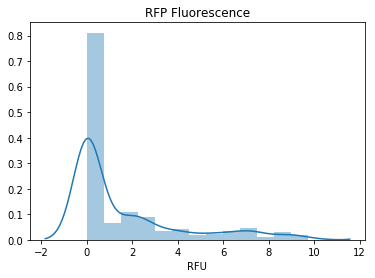

In [50]:
sns.distplot(a=[d['_TxR.tif_fluor'] for d in fluorescence_droplets])
plt.title('RFP Fluorescence')
plt.xlabel('RFU')

In [55]:
fluor_df = pd.DataFrame()
fluor_df['RFP'] = [d['_TxR.tif_fluor'] for d in fluorescence_droplets]
fluor_df.to_csv('fluorescence.csv')

# 6) Count cells, if you want

In [ ]:
counted_droplets = []
for d in masked_droplets:
    counted_droplet = dat.countCellsInDrop(d, YFP_TAG)
    counted_droplet = dat.countCellsInDrop(counted_droplet, RFP_TAG)
    counted_droplet = dat.countCellsInDrop(counted_droplet, CFP_TAG)
    counted_droplets.append(counted_droplet)

In [ ]:
dat.printDropletMatrix(counted_droplets, channels=[YFP_TAG+'_cellregion'], filename='grid_count_YFP.png')
dat.printDropletMatrix(counted_droplets, channels=[RFP_TAG+'_cellregion'], filename='grid_count_RFP.png')
dat.printDropletMatrix(counted_droplets, channels=[CFP_TAG+'_cellregion'], filename='grid_count_CFP.png')

In [ ]:
dat.printSortedDropletMatrix(counted_droplets, FLUOR_TAGS, filename='sorted_droplet_matrix.png')

In [ ]:
full_droplets, empty_droplets = dat.subsetWhereNonempty(masked_droplets)
dat.printDropletMatrix(full_droplets, channels=dat.channelsWithSuffix(TAGS, '_whiteline'), filename='grid_full_channels.png')
dat.printDropletMatrix(full_droplets, channels=dat.channelsWithSuffix(FLUOR_TAGS, '_whiteline'), filename='grid_full_fluor.png')
dat.printDropletMatrix(empty_droplets, channels=dat.channelsWithSuffix(TAGS, '_whiteline'), filename='grid_empty_channels.png')

# 6) Plots

#### count_df stores counts of cells for each droplet

In [ ]:
count_df = dat.dropletsToDF(counted_droplets).astype(int)
count_df = count_df.rename(index=str, columns={
    '_TxR.tif_cellcount':'RFP_count',
    '_YFP.tif_cellcount':'YFP_count',
    '_CFP.tif_cellcount':'CFP_count'
})

In [ ]:
def getSpecificPairOrLess(condition1, condition2, original_df):
    df = original_df.copy()
    cols = df.columns.copy()
    truth=[]
    print cols
    for c in cols:
        if c not in [condition1, condition2]:
            truth.append(df[c] == 0)
    for t in truth:
        df = df[t]
    return df.copy()

In [ ]:
def getSpecificStrain(condition1, original_df):
    df = original_df.copy()
    cols = df.columns.copy()
    truth=[]
    for c in cols:
        if c not in [condition1]:
            truth.append(df[c] == 0)
    for t in truth:
        df = df[t]
    return df.copy()

In [ ]:
sns.set_context('talk', font_scale=1.5)

### Lambda

In [ ]:
import scipy as sp
def poisson(k, l):
    l=float(l)
    return ((l**k)*(np.exp(-l))) / (np.math.factorial(k))

def percentZerosToLambda(percent):
    opt = sp.optimize.curve_fit(poisson, [0], [percent])
    return np.round(opt[0][0], 2)

In [ ]:
sum_cells_array = [np.sum(row.as_matrix()) for index, row in count_df.iterrows()]

n_full = np.count_nonzero(sum_cells_array)
n_empty = len(sum_cells_array) - n_full
n_total = len(sum_cells_array)

In [ ]:
print 'FULL  DROPLETS: ', n_full
print 'EMPTY DROPLETS: ', n_empty
print 'TOTAL DROPLETS: ', n_total

print 'EFFECTIVE LAMBDA: ', percentZerosToLambda(1.*n_empty/n_total) 

# 6) Fitness Changes

In [ ]:
sns_palette = sns.color_palette("hls", 12)

sns_red = sns_palette[0]
sns_yellow = sns_palette[2]
sns_green = sns_palette[3]
sns_cyan = sns_palette[6]

material_red = '#F44336'
material_cyan = '#00BCD4'
material_yellow = '#FFEB3B'

In [ ]:
conditions = ['RFP_count', 'CFP_count', 'YFP_count']
colors = [material_red, material_cyan, material_yellow]

In [ ]:
pair_df = pd.DataFrame()

for mainStrain in conditions:
    single_strain_df = pd.DataFrame()
    for partnerStrain in conditions:
        ind_count_df = pd.DataFrame()
        spec_pair_df = getSpecificPairOrLess(mainStrain, partnerStrain, count_df)
        spec_pair_df = spec_pair_df[spec_pair_df[mainStrain] > 0]
        spec_pair_df = spec_pair_df[spec_pair_df[partnerStrain] > 0]    
        temp_series = spec_pair_df[spec_pair_df[mainStrain] > 0][mainStrain]
        ind_count_df['count'] = temp_series
        ind_count_df['strain'] = [mainStrain.split('_')[0]]*len(ind_count_df)
        ind_count_df['grown with'] = [partnerStrain.split('_')[0]]*len(ind_count_df)
        single_strain_df = single_strain_df.append(ind_count_df, ignore_index=True)
         
    mean_self_count = np.mean(single_strain_df[single_strain_df['grown with']==mainStrain.split('_')[0]]['count'])
    single_strain_df['relative growth'] = single_strain_df['count']/mean_self_count
    pair_df = pair_df.append(single_strain_df)

In [ ]:
sns.set_context('talk', font_scale=1.5)

### Absolute count change

In [ ]:
dat.saveInteractionPlot(x='strain', y='count', z='grown with',
                    df=pair_df, colors=colors, kind='bar',
                    title='Count of cells per drop',
                    filename='abs_bar_partner.png', yIsOne=False)

### Relative count change

In [ ]:
dat.saveInteractionPlot(x='strain', y='relative growth', z='grown with',
                    df=pair_df, colors=colors, kind='bar',
                    title='Relative growth per drop',
                    filename='rel_bar_partner.png', yIsOne=True)

In [ ]:
dat.saveInteractionPlot(x='strain', y='relative growth', z='grown with',
                    df=pair_df, colors=colors, kind='swarm',
                    title='Relative growth per drop',
                    filename='rel_swr_partner.png', yIsOne=True)


# 7) Interaction Network

In [ ]:
dat.exportInteractionNetwork(pair_df)

In [ ]:
TIMEPOINT = 18

In [ ]:
output_df = pair_df.copy()
output_df['timepoint (hrs)'] = [TIMEPOINT] * len(pair_df)
output_df['experiment'] = [RAW_IMAGE_DIR] * len(pair_df)
output_df = output_df.reset_index()
output_df.to_csv(PLOT_OUTPUT_DIR + 'output_df.csv')
output_df.to_json(PLOT_OUTPUT_DIR + 'output_df.json')

In [ ]:
count_output_df = count_df.copy()
count_output_df['timepoint (hrs)'] = [TIMEPOINT] * len(count_output_df)
count_output_df['experiment'] = [RAW_IMAGE_DIR] * len(count_output_df)
count_output_df = count_output_df.reset_index()
count_output_df.to_csv(PLOT_OUTPUT_DIR + 'count_output_df.csv')
count_output_df.to_json(PLOT_OUTPUT_DIR + 'count_output_df.json')
count_output_df